## Extract and normalize hand landmarks

In [1]:
from __future__ import annotations

import json
import glob
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mediapipe.python.solutions.face_mesh import FACEMESH_LIPS

2023-08-16 08:48:42.143813: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 08:48:42.702824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Define landmark column names

In [2]:
left_hand_columns = [
    f"{axis}_left_hand_{index}"
    for index in range(21)
    for axis in "xyz"
]
right_hand_columns = [
    f"{axis}_right_hand_{index}"
    for index in range(21)
    for axis in "xyz"
]
arms_columns = [
    f"{axis}_pose_{index}"
    for index in range(11, 25)
    for axis in "xyz"
]
lips_columns = [
    f"{axis}_face_{index}"
    for index in sorted(set(sum(map(list, FACEMESH_LIPS), [])))
    for axis in "xyz"
]
columns = left_hand_columns + right_hand_columns + arms_columns + lips_columns
len(columns) // 3, len(columns)

(96, 288)

In [3]:
columns[:10]

['x_left_hand_0',
 'y_left_hand_0',
 'z_left_hand_0',
 'x_left_hand_1',
 'y_left_hand_1',
 'z_left_hand_1',
 'x_left_hand_2',
 'y_left_hand_2',
 'z_left_hand_2',
 'x_left_hand_3']

In [4]:
print(len(left_hand_columns) // 3)
print(len(arms_columns) // 3)
print(len(lips_columns) // 3)

21
14
40


### Extract landmarks from parquets

In [5]:
train_hand_landmarks = {}
for filename in tqdm.tqdm(glob.glob("train_landmarks/*.parquet")):
    for seq_id, df in pd.read_parquet(filename).groupby("sequence_id"):
        train_hand_landmarks[seq_id] = df[left_hand_columns + right_hand_columns].to_numpy()

100%|██████████| 68/68 [02:19<00:00,  2.05s/it]


In [6]:
supplemental_hand_landmarks = {}
for filename in tqdm.tqdm(glob.glob("supplemental_landmarks/*.parquet")):
    for seq_id, df in pd.read_parquet(filename).groupby("sequence_id"):
        supplemental_hand_landmarks[seq_id] = df[left_hand_columns + right_hand_columns].to_numpy()

100%|██████████| 53/53 [01:53<00:00,  2.15s/it]


### Estimate affine transform matrix and find axis scale

In [7]:
standard_hand = np.array(
    [
        [5.07927835e-01, 8.09575438e-01],
        [6.19768918e-01, 7.14033902e-01],
        [6.97901249e-01, 5.90922773e-01],
        [7.74790943e-01, 4.93720263e-01],
        [8.50507736e-01, 4.35694307e-01],
        [5.40026903e-01, 4.32799399e-01],
        [5.41218460e-01, 2.89591074e-01],
        [5.42616606e-01, 1.98928684e-01],
        [5.41074634e-01, 1.19834989e-01],
        [4.55297321e-01, 4.34886426e-01],
        [4.38045800e-01, 2.81298965e-01],
        [4.25656796e-01, 1.79603398e-01],
        [4.12055492e-01, 9.64773595e-02],
        [3.80906552e-01, 4.70337212e-01],
        [3.35969508e-01, 3.32161725e-01],
        [3.11885774e-01, 2.44850174e-01],
        [2.94146836e-01, 1.72753423e-01],
        [3.19318265e-01, 5.33898830e-01],
        [2.44915754e-01, 4.52630371e-01],
        [1.96688622e-01, 3.95348072e-01],
        [1.59547806e-01, 3.37536871e-01]
    ]
)
affine_estimate_points = [0, 5, 17]

In [8]:
def solve_affine_matrix(src: np.ndarray, dst: np.ndarray) -> np.ndarray | None:
    right = np.zeros((6, 6))
    for i in range(3):
        right[2 * i, 0:2] = right[2 * i + 1, 3:5] = src[i]
        right[2 * i, 2] = right[2 * i + 1, 5] = 1
    if np.linalg.det(right) == 0:
        return None
    return (np.linalg.inv(right) @ dst.flatten()).reshape(2, 3)

In [9]:
y_scales = []
for data in tqdm.tqdm(list(train_hand_landmarks.values()) + list(supplemental_hand_landmarks.values())):
    for hand_frames in (data[:, :63], data[:, 63:126]):
        hand_frames = hand_frames[~np.isnan(hand_frames).all(1)]
        hand_frames = np.nan_to_num(hand_frames, nan=0.0)
        hand_frames = hand_frames.reshape(-1, 21, 3)

        for hand in hand_frames:
            A = solve_affine_matrix(
                src=hand[affine_estimate_points][:, :2],
                dst=standard_hand[affine_estimate_points],
            )
            if A is not None:
                S = np.linalg.norm(A[:, :2], axis=0)
                y_scales.append(S[1] / S[0])
y_scales = np.stack(y_scales)
y_scales = y_scales[y_scales < 5]
y_scale = y_scales.mean()

100%|██████████| 120244/120244 [06:10<00:00, 324.58it/s]


In [10]:
del train_hand_landmarks
del supplemental_hand_landmarks

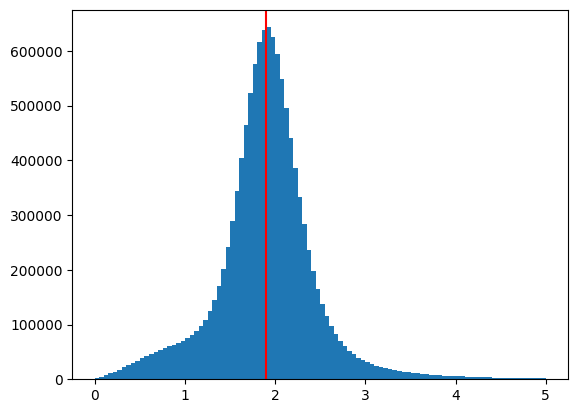

In [11]:
plt.hist(y_scales, bins=100)
plt.axvline(y_scale, color="r")
plt.show()

### Save the normalized landmarks

In [12]:
!mkdir train_landmarks_npy

for filename in tqdm.tqdm(glob.glob("train_landmarks/*.parquet")):
    for seq_id, df in pd.read_parquet(filename).groupby("sequence_id"):
        landmarks = df[columns].to_numpy().reshape(-1, 96, 3)
        landmarks[:, :, 1] *= y_scale
        landmarks = landmarks.reshape(-1, 288)
        np.save(f"train_landmarks_npy/{seq_id}.npy", landmarks.astype(np.float32))

100%|██████████| 68/68 [02:40<00:00,  2.36s/it]


In [13]:
!mkdir supplemental_landmarks_npy

for filename in tqdm.tqdm(glob.glob("supplemental_landmarks/*.parquet")):
    for seq_id, df in pd.read_parquet(filename).groupby("sequence_id"):
        landmarks = df[columns].to_numpy().reshape(-1, 96, 3)
        landmarks[:, :, 1] *= y_scale
        landmarks = landmarks.reshape(-1, 288)
        np.save(f"supplemental_landmarks_npy/{seq_id}.npy", landmarks.astype(np.float32))

100%|██████████| 53/53 [02:12<00:00,  2.51s/it]
